<a href="https://colab.research.google.com/github/htapiagroup/sistemas-distribuidos-evaluacion-intersemestral-BaezCrdrm/blob/Avances/MCA_SistDist_Ex1_SBH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistemas Distribuidos

## Primera evaluacion

Se evaluaran los siguientes puntos:

### Importar datos

1. Adquirir los datos.
> * El conjunto de datos con el que van a trabajar esta disponibles en [este enlace](https://archive.org/download/nycTaxiTripData2013/trip_data.7z) y consiste en 12 archivos de texto que tiene informacion del viajes de taxis en la ciudad de NY durante el 2013.
> * En la red interna de LANIA usando cable la descarga del archivo comprimido desde el enlace tomó entre 5 y 10 minutos. Tomen sus provisiones
> * El archivo comprimido tiene un tamaño de aproximadamente 4G, el tamaño de archivo mensual oscila entre 2.0 y 2.5G. La base de datos completa es de aproximadamente 30G.
2. Una vez descargado el archivo pueden descomprimirlo usando la siguiente instruccion
>` !7z x trip_data.7z -o/content/`
sin embargo si intentan descomprimir todos los archivos en su sesion se van a terminar el espacio de disco disponible. En esta practica solo van a trabajar con datos correspondientes a los primeros cuatro meses. 
3. Responder las siguientes preguntas:
   1. Cuantas columnas contiene cada archivo de datos descomprimido
   2. Cuantos renglones tiene cada archivo
4. Identificar si existen renglones con errores en los datos, por ejemplo si hay columnas de mas (o de menos), si hay campos vacios, etc. Si se detectan renglones con errores:
    1. indicar claramente cuantos son los renglones con errores y a que archivos corresponden
    2. crear un nuevo conjunto de datos con los errores eliminados
5. Crear un `DataFrame` usando la libreria `pandas` y responder lo siguiente:
   1. Indicar el tiempo en segundos, que  tarda la libreria `pandas` en leer un archivo a un  `DataFrame`
   2. Cual es la huella de memoria del proceso usado para generar el objeto `DataFrame`
   2. Cuanta memoria del sistema se usa para crear el objeto anterior
   3. Indicar el tiempo que tarda `pandas` en obtener el promedio de la distancia de viaje (`trip_distance`)
6. Todos los pasos siguientes deben **realizarse** usando la libreria `dask`
   3. Indicar el tiempo que tarda en obtener el promedio de la distancia de viaje (`trip_distance`)
   3. Indicar el tiempo que tarda en obtener el promedio de la duracion de viaje (`trip_time_in_secs`)
   4. Con las columnas `pickup_datetime` y `dropoff_datetime` como objetos temporales, crear una nueva columna en los dataframes que se llame `duracion` y compararla renglon a renglon con la columna `trip_time_in_secs`
   5. Definir un `viaje_largo` como aquellos en los que la duracion del viaje (`trip_time_in_secs`) sea mayor a 20 minutos.
7. Contar el numero de viajes largos en cada archivo
8. De los viajes largos, identificar el numero de taxis diferentes (la columna `medallion` contiene un numeroque identificada a cada uno de los vehiculos). Que vehiculos son los que mas viajes realizan en cada mes? Son el mismo vehiculo?
9. Hacer una grafica temporal del numero total de pasajeros agregados por dias de la semana y despues por horas del dia. Sugerencia: agregar por el correspondiente periodo temporal y graficar. Que pueden observar de las graficas?
10. Elegir el vehiculo con mas viajes en cada mes y graficar en un mapa los sitios donde se suben pasajeros agrupados por
   * dia de la semana (un color distinto para cada dia)
   * hora del dia (un color distinto para cada intervalo de cuatro horas,00:00 - 03:59, 04:00--07:59, 08:00-11:59, etc.)
11. Repetir para las posiciones donde se bajan los pasajeros para el mismo vehiculo.


## 1. Adquisición de los datos


# Desarrollo y comprobación
Este segmento contiene toda la información realizada para responder las preguntas establecidas.

## En colaboración:
- Luis Daniel Hernandez Jimenez
- Alexis Martínez Arteaga
- Jose David Cobos Trujillo
- Lorrain Eugenio Giddings Soto
- Yoselin Araceli Campos Sacramento
- Ana Margarita Reyes Hernandez
- Joaquin Aguilar Hernandez
- Georgina Valenzuela Carrasco
- Horacio Tapia McClung

In [0]:
import psutil, os
import pandas as pd, time
import matplotlib.pyplot as plt

La función `huella_memoria` fue obtenida de las libretas de cuadernos anteriores.

In [0]:
def huella_memoria():
    ''' Regresa la juella de memoria en MB usada por un proceso de Python'''
    mem = psutil.Process(os.getpid()).memory_info().rss
    return (mem / 1024**2)

## 1. Adquirir los datos

Agregar Google Drive para no tener que descargar los datos.

In [12]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [13]:
cd /content/gdrive/My\ Drive/'Colab Notebooks'

/content/gdrive/My Drive/Colab Notebooks


In [14]:
ls

 Amazon1.ipynb                            SD_S1_L1.ipynb
 AprendizajeSupervisado.ipynb             SD_S2_L1.ipynb
'Copie de AprendizajeSupervisado.ipynb'   SD_S2_L2.ipynb
'Copy of Genetico2.1.ipynb'               SD_S3_L1.ipynb
'Copy of Genetico3.1.ipynb'               SD_S4_L1.ipynb
'Copy of SD_S2_L1.ipynb'                  SD_S5_L1.ipynb
 Evaluacion/                              SD_S6_L1.ipynb
 Examen1.1.ipynb                          SD_S6_L2.ipynb
 Examen_Matematicas.ipynb                'Steepest Ascent Hill-Climbing.ipynb'
 Genetico2.1.ipynb                        TI2_1.ipynb
 Genetico2.ipynb                          Untitled
 Genetico3.ipynb                          Untitled0.ipynb
 MCA_SistDist_Ex1_SBH.ipynb               Untitled1.ipynb
 Prueba1.ipynb                            Untitled2.ipynb
 Reinas1.ipynb                            Untitled3.ipynb
 SD2/


In [0]:
if not os.path.exists('Evaluacion'):
    os.mkdir('Evaluacion')

In [59]:
cd Evaluacion/

/content/gdrive/My Drive/Colab Notebooks/Evaluacion


In [60]:
ls

mydask.png  trip_data.7z


In [0]:
if not os.path.exists("trip_data.7z"):
    !wget https://archive.org/download/nycTaxiTripData2013/trip_data.7z

## Pandas Versión 1
Un sólo archivo. Para entrega del [martes 18 de junio](https://github.com/htapiagroup/sistemas-distribuidos-evaluacion-intersemestral-BaezCrdrm/blob/0c178f606223985b407d9e467ec42823b555fbd7/MCA_SistDist_Ex1_SBH.ipynb).

### 2. Descomprime datos

#### Descomprime un sólo archivo de datos descargados.

In [0]:
!7z e trip_data.7z -o/content/gdrive/My\ Drive/Colab\ Notebooks/Evaluacion/Data trip_data_1.csv


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 4102781969 bytes (3913 MiB)

Extracting archive: trip_data.7z
--
Path = trip_data.7z
Type = 7z
Physical Size = 4102781969
Headers Size = 433
Method = LZMA:24
Solid = -
Blocks = 12

  0%      0% - trip_data_1.csv                        1% - trip_data_1.csv                        2% - trip_data_1.csv                        3% - trip_data_1.csv                      
Archives with Errors: 1



Break signaled


In [0]:
cd Data

/content/gdrive/My Drive/Colab Notebooks/Evaluacion/Data


### 5. Crear un `DataFrame` usando la libreria `pandas`.

In [0]:
# Tiempo y memoria
t_start = time.time()
mem_antes = huella_memoria()

df = pd.read_csv('trip_data_1.csv')

# Tiempo y memoria
mem_despues = huella_memoria()
t_end = time.time()

### 3. Preguntas

Contar dimensiones del dataframe.

Hay `14776615` registros y `14` variables/columnas.

In [0]:
df.shape

(14776615, 14)

### 4. Identificar si existen renglones con errores en los datos, por ejemplo si hay columnas de mas (o de menos), si hay campos vacios, etc. Si se detectan renglones con errores:

In [0]:
df.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.0,-73.978165,40.757977,-73.989838,40.751171
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.5,-74.006683,40.731781,-73.994499,40.750660
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.1,-74.004707,40.737770,-74.009834,40.726002
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,0.7,-73.974602,40.759945,-73.984734,40.759388
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.1,-73.976250,40.748528,-74.002586,40.747868


#### 0. Verificar errores
Crear un nuevo conjunto de datos con los errores eliminados.

Verificar errores en el Dataframe y limpiar los errores nulos y NaN que pudieran afectar al DataFrame.

##### Limpiar data frame

In [0]:
df.isna().sum()

medallion                   0
hack_license                0
vendor_id                   0
rate_code                   0
store_and_fwd_flag    7326207
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
trip_time_in_secs           0
trip_distance               0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude          86
dropoff_latitude           86
dtype: int64

In [0]:
df = df.dropna(how='all', subset=['dropoff_longitude', 'dropoff_latitude'])

##### Eliminar columnas

In [0]:
df = df.drop('store_and_fwd_flag', axis=1)

In [0]:
df.isna().sum()

medallion            0
hack_license         0
vendor_id            0
rate_code            0
pickup_datetime      0
dropoff_datetime     0
passenger_count      0
trip_time_in_secs    0
trip_distance        0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
dtype: int64

**Al limpiar el resultado** es igual a:

14776529 registros y 13 columnas/variables.

In [0]:
df.shape

(14776529, 13)

#### 5.1 Indicar el tiempo en segundos, que  tarda la libreria `pandas` en leer un archivo a un  `DataFrame.

In [0]:
print('Tiemo de lectura: {} s'.format(t_end - t_start))

Tiemo de lectura: 102.31801748275757 s


#### 5.2 Cual es la huella de memoria del proceso usado para generar el objeto `DataFrame.

In [0]:
print('Huella de memoria: {} MB'.format(mem_despues - mem_antes))

Huella de memoria: 4962.84765625 MB


#### 5.3 Cuanta memoria del sistema se usa para crear el objeto anterior.

_En colaboración con **David Cobos**_

In [0]:
print('Memoria del sistema: {} MB'.format(huella_memoria()))

Memoria del sistema: 6348.74609375 MB


#### 5.4 Indicar el tiempo que tarda `pandas` en obtener el promedio de la distancia de viaje (`trip_distance`).

_En colaboración con **Alexis Martínez**_

In [0]:
# Tiempo y memoria
t_start = time.time()
mem_antes = huella_memoria()

no_ceros = (df['trip_distance'] != 0)
promedio_total_distancia_viaje = no_ceros.mean()

# Tiempo y memoria
mem_despues = huella_memoria()
t_end = time.time()

In [0]:
print('Tiemo de lectura: {} s'.format(t_end - t_start))
# print('Uso de memoria: {} MB'.format(mem_despues - mem_antes))

Tiemo de lectura: 0.0654911994934082 s


## Pandas Versión 2
Involucra el llevar a cabo los pasos **2, 5, 3 y 4** con la carga de cuatro archivos en la librería Pandas.

In [0]:
if not os.path.exists("/content/sample_data/Data/"):
    os.mkdir("/content/sample_data/Data/")

In [0]:
total_archivos = 4
archivo_temp = "trip_data_{}.csv"
ruta = "/content/sample_data/Data/" + archivo_temp
archivos = [ruta.format(k) for k in range(1, total_archivos + 1)]
comando = "7z e trip_data.7z -o/content/sample_data/Data " + archivo_temp
comandos = [comando.format(k) for k in range(1, total_archivos + 1)]

In [0]:
comandos

['7z e trip_data.7z -o/content/sample_data/Data trip_data_1.csv',
 '7z e trip_data.7z -o/content/sample_data/Data trip_data_2.csv',
 '7z e trip_data.7z -o/content/sample_data/Data trip_data_3.csv',
 '7z e trip_data.7z -o/content/sample_data/Data trip_data_4.csv']

In [0]:
archivos

['/content/sample_data/Data/trip_data_1.csv',
 '/content/sample_data/Data/trip_data_2.csv',
 '/content/sample_data/Data/trip_data_3.csv',
 '/content/sample_data/Data/trip_data_4.csv']

In [0]:
%%time
resultados = []
memoria = []
dimensiones = []
tiempos = []
for i in range(total_archivos):
    print("Desempaqueta {}".format(archivos[i]))
    t_start = time.time()
    if not os.path.exists(archivos[i]):
        os.system(comandos[i])
    archivo = archivos[i]
       
    print("Crea Dataframe")
    antes = huella_memoria()
    df = pd.read_csv(archivo)
    dimensiones.append(df.shape)
    
    print("Limpia Dataframe")
    df.columns = df.columns.str.strip()
    df = df.drop('store_and_fwd_flag', axis=1)
    df = df.dropna(how='all', subset=['dropoff_longitude', 'dropoff_latitude'])
    despues = huella_memoria()
    
    memoria.append(despues - antes)
    
    no_ceros = (df['trip_distance'] != 0)
    
    print("Agregando resultados")
    resultados.append(no_ceros.mean())
    
    print("Remueve el archivo de almacenamiento")
    os.remove(archivos[i])
    
    print("")
    t_end = time.time()
    tiempos.append(t_end - t_start)

Desempaqueta /content/sample_data/Data/trip_data_1.csv
Crea Dataframe
Limpia Dataframe
Agregando resultados
Remueve el archivo de almacenamiento

Desempaqueta /content/sample_data/Data/trip_data_2.csv
Crea Dataframe


<string>:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.


Limpia Dataframe
Agregando resultados
Remueve el archivo de almacenamiento

Desempaqueta /content/sample_data/Data/trip_data_3.csv
Crea Dataframe
Limpia Dataframe
Agregando resultados
Remueve el archivo de almacenamiento

Desempaqueta /content/sample_data/Data/trip_data_4.csv
Crea Dataframe
Limpia Dataframe
Agregando resultados
Remueve el archivo de almacenamiento

CPU times: user 3min 39s, sys: 34.7 s, total: 4min 14s
Wall time: 7min 31s


In [0]:
resultados

[0.9943633582690495,
 0.9947297592584108,
 0.9946961492951746,
 0.9925749265479239]

### Resultados
A la carga de 4 archivos en Pandas Dataframes

In [0]:
resp_template = ("Para el mes {0}, el promedio de la distancia de viaje \"trip_distance\" es de {1} millas. " + 
    "\nEl dataframe cargado cuenta con las dimensiones de {2}.\nEl proceso utilizó {3} MB de memoria y tomó {4} s en completarse.\n")
for i in range(len(resultados)):
    print(resp_template.format(i + 1, round(resultados[i], 4), dimensiones[i], memoria[i], round(tiempos[i], 2)))

Para el mes 1, el promedio de la distancia de viaje "trip_distance" es de 0.9944 millas. 
El dataframe cargado cuenta con las dimensiones de (14776615, 14).
El proceso utilizó 1927.95703125 MB de memoria y tomó 110.27 s en completarse.

Para el mes 2, el promedio de la distancia de viaje "trip_distance" es de 0.9947 millas. 
El dataframe cargado cuenta con las dimensiones de (13990176, 14).
El proceso utilizó 1123.1640625 MB de memoria y tomó 107.0 s en completarse.

Para el mes 3, el promedio de la distancia de viaje "trip_distance" es de 0.9947 millas. 
El dataframe cargado cuenta con las dimensiones de (15749228, 14).
El proceso utilizó 2365.98828125 MB de memoria y tomó 121.6 s en completarse.

Para el mes 4, el promedio de la distancia de viaje "trip_distance" es de 0.9926 millas. 
El dataframe cargado cuenta con las dimensiones de (15100468, 14).
El proceso utilizó 2409.66796875 MB de memoria y tomó 112.14 s en completarse.



## 6. Dask

Todos los pasos siguientes deben **realizarse** usando la libreria `dask`
   3. Indicar el tiempo que tarda en obtener el promedio de la distancia de viaje (`trip_distance`)
   3. Indicar el tiempo que tarda en obtener el promedio de la duracion de viaje (`trip_time_in_secs`)
   4. Con las columnas `pickup_datetime` y `dropoff_datetime` como objetos temporales, crear una nueva columna en los dataframes que se llame `duracion` y compararla renglon a renglon con la columna `trip_time_in_secs`
   5. Definir un `viaje_largo` como aquellos en los que la duracion del viaje (`trip_time_in_secs`) sea mayor a 20 minutos.

In [0]:
import dask
import dask.dataframe as dd
from dask import delayed

In [0]:
if not os.path.exists("/content/sample_data/Data/"):
    os.mkdir("/content/sample_data/Data/")

In [0]:
total_archivos = 12
archivo_temp = "trip_data_{}.csv"
ruta = "/content/sample_data/Data/"
rutac = ruta + archivo_temp
archivos = [rutac.format(k) for k in range(1, total_archivos + 1)]
comando = "7z e '/content/gdrive/My Drive/Colab Notebooks/Evaluacion/trip_data.7z' -o/content/sample_data/Data " + archivo_temp
comandos = [comando.format(k) for k in range(1, total_archivos + 1)]

In [69]:
ls

mydask.png  trip_data.7z


In [0]:
import numpy as np
ac = np.array([archivos, comandos]).T
ac = ac.tolist()

In [71]:
for i in ac:
    print("Imprimio")
    print(i)

Imprimio
['/content/sample_data/Data/trip_data_1.csv', "7z e '/content/gdrive/My Drive/Colab Notebooks/Evaluacion/trip_data.7z' -o/content/sample_data/Data trip_data_1.csv"]
Imprimio
['/content/sample_data/Data/trip_data_2.csv', "7z e '/content/gdrive/My Drive/Colab Notebooks/Evaluacion/trip_data.7z' -o/content/sample_data/Data trip_data_2.csv"]
Imprimio
['/content/sample_data/Data/trip_data_3.csv', "7z e '/content/gdrive/My Drive/Colab Notebooks/Evaluacion/trip_data.7z' -o/content/sample_data/Data trip_data_3.csv"]
Imprimio
['/content/sample_data/Data/trip_data_4.csv', "7z e '/content/gdrive/My Drive/Colab Notebooks/Evaluacion/trip_data.7z' -o/content/sample_data/Data trip_data_4.csv"]
Imprimio
['/content/sample_data/Data/trip_data_5.csv', "7z e '/content/gdrive/My Drive/Colab Notebooks/Evaluacion/trip_data.7z' -o/content/sample_data/Data trip_data_5.csv"]
Imprimio
['/content/sample_data/Data/trip_data_6.csv', "7z e '/content/gdrive/My Drive/Colab Notebooks/Evaluacion/trip_data.7z' -o

In [0]:
hasta_archivo = 4
aac = [ac[i] for i in range(hasta_archivo)]

In [0]:
tiempos = []
def limpiar(k):
    archivo = k[0]
    if not os.path.exists(archivo):
        os.system(k[1])
        
    df = dd.read_csv(archivo, assume_missing=True, dtype="str")
    df.columns = df.columns.str.strip()
    df = df.drop('store_and_fwd_flag', axis=1)
    df = df.dropna(how='all', subset=['dropoff_longitude', 'dropoff_latitude'])
    # os.remove(archivo)
    
    return df

Carga los Dataframes en modo _delayed_. Implementación inspirada de https://stackoverflow.com/a/44502887

_**Nota:** falla en conseguir unir los dataframes en uno sólo. Da el error:_


```bash
ValueError: Metadata mismatch found in `from_delayed`.Expected partition of type `DataFrame` but got `DataFrame`
```

Se comenta la línea `ddf = dd.from_delayed(delayed_df)` y se deja para futura referencia y probable uso.


In [0]:
# https://stackoverflow.com/a/44502887
# delayed_df = [delayed(limpiar)(k) for k in aac]
# ddf = dd.from_delayed(delayed_df)

In [75]:
aac

[['/content/sample_data/Data/trip_data_1.csv',
  "7z e '/content/gdrive/My Drive/Colab Notebooks/Evaluacion/trip_data.7z' -o/content/sample_data/Data trip_data_1.csv"],
 ['/content/sample_data/Data/trip_data_2.csv',
  "7z e '/content/gdrive/My Drive/Colab Notebooks/Evaluacion/trip_data.7z' -o/content/sample_data/Data trip_data_2.csv"],
 ['/content/sample_data/Data/trip_data_3.csv',
  "7z e '/content/gdrive/My Drive/Colab Notebooks/Evaluacion/trip_data.7z' -o/content/sample_data/Data trip_data_3.csv"],
 ['/content/sample_data/Data/trip_data_4.csv',
  "7z e '/content/gdrive/My Drive/Colab Notebooks/Evaluacion/trip_data.7z' -o/content/sample_data/Data trip_data_4.csv"]]

In [0]:
ddf = [limpiar(k) for k in aac]
for i in range(len(ddf)):
    ddf[i]['archivo'] = i + 1

In [25]:
len(aac)

4

In [0]:
aaa = dd.concat([part for part in ddf])

In [27]:
aaa.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,archivo
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.00,-73.978165,40.757977,-73.989838,40.751171,1
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.50,-74.006683,40.731781,-73.994499,40.75066,1
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.10,-74.004707,40.73777,-74.009834,40.726002,1
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,.70,-73.974602,40.759945,-73.984734,40.759388,1
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.10,-73.97625,40.748528,-74.002586,40.747868,1


In [0]:
# pickup_datetime y dropoff_datetime
aaa['pickup_datetime'] = dd.to_datetime(aaa['pickup_datetime'])
aaa['dropoff_datetime'] = dd.to_datetime(aaa['dropoff_datetime'])
aaa['duracion'] = aaa['dropoff_datetime'] - aaa['pickup_datetime']

In [0]:
pdv = []
def promedio_distancia_viaje(data):
    data['trip_distance'] = data['trip_distance'].astype(float)
    prom_trip_distance = data['trip_distance'].mean()
    return prom_trip_distance

def cen_pdv(data):
    prom = promedio_distancia_viaje(data).compute()
    pdv.append(prom)

In [0]:
prom_distancia = promedio_distancia_viaje(aaa).compute()

In [31]:
print(prom_distancia)

2.7900190440284973


In [0]:
aaa['trip_distance'] = aaa['trip_distance'].astype(float)
prom_trip_distance = aaa['trip_distance'].mean()

In [0]:
def promedio_tiempo_segundos(data):
    data['trip_time_in_secs'] = data['trip_time_in_secs'].astype(float)
    prom_trip_time_in_secs = data['trip_time_in_secs'].mean()
    return prom_trip_time_in_secs

In [0]:
pts = []
def cen_pt(data):
    print("cen_pt")
    prom_tiempo = promedio_tiempo_segundos(data).compute()
    print("append cen_pt")
    pts.append(prom_tiempo)

In [39]:
pts

[701.7384393732381]

In [46]:
aac

[['/content/sample_data/Data/trip_data_1.csv',
  '7z e trip_data.7z -o/content/sample_data/Data trip_data_1.csv'],
 ['/content/sample_data/Data/trip_data_2.csv',
  '7z e trip_data.7z -o/content/sample_data/Data trip_data_2.csv'],
 ['/content/sample_data/Data/trip_data_3.csv',
  '7z e trip_data.7z -o/content/sample_data/Data trip_data_3.csv'],
 ['/content/sample_data/Data/trip_data_4.csv',
  '7z e trip_data.7z -o/content/sample_data/Data trip_data_4.csv']]

In [0]:
ddf = [limpiar(k) for k in aac]

In [0]:
data = dd.concat([part for part in ddf])

In [53]:
data

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
npartitions=120,,,,,,,,,,,,,
,object,object,object,object,object,object,object,object,object,object,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...


In [77]:
stages = len(ac) // 3
starting_index = 0
for seccion in range(0, len(ac), stages):
    aac = [ac[i] for i in range(starting_index, seccion + stages)]
    for i in aac:
        print(i)

    ddf = [limpiar(k) for k in aac]
    data = dd.concat([part for part in ddf])
    cen_pt(data)
    
    print("Borrar")
    for cmd in aac:
        print(cmd[0])
        os.remove(cmd[0])

    print("")
    starting_index += stages

['/content/sample_data/Data/trip_data_1.csv', "7z e '/content/gdrive/My Drive/Colab Notebooks/Evaluacion/trip_data.7z' -o/content/sample_data/Data trip_data_1.csv"]
['/content/sample_data/Data/trip_data_2.csv', "7z e '/content/gdrive/My Drive/Colab Notebooks/Evaluacion/trip_data.7z' -o/content/sample_data/Data trip_data_2.csv"]
['/content/sample_data/Data/trip_data_3.csv', "7z e '/content/gdrive/My Drive/Colab Notebooks/Evaluacion/trip_data.7z' -o/content/sample_data/Data trip_data_3.csv"]
['/content/sample_data/Data/trip_data_4.csv', "7z e '/content/gdrive/My Drive/Colab Notebooks/Evaluacion/trip_data.7z' -o/content/sample_data/Data trip_data_4.csv"]
cen_pt
append cen_pt
Borrar
/content/sample_data/Data/trip_data_1.csv
/content/sample_data/Data/trip_data_2.csv
/content/sample_data/Data/trip_data_3.csv
/content/sample_data/Data/trip_data_4.csv

['/content/sample_data/Data/trip_data_5.csv', "7z e '/content/gdrive/My Drive/Colab Notebooks/Evaluacion/trip_data.7z' -o/content/sample_data/D

In [81]:
pts

[701.7384393732381, 719.5405026624702, 947.2954133059718, 782.9574500934729]

In [0]:
prom_tiempo = promedio_tiempo_segundos(aaa).compute()

In [35]:
print(prom_tiempo)

701.7384393732381


In [0]:
# trip_time_in_secs
aaa['trip_time_in_secs'] = aaa['trip_time_in_secs'].astype(float)
prom_trip_time_in_secs = aaa['trip_time_in_secs'].mean()

_No entendí este punto. Sí entendí que había que comparar los valores, pero no sé dónde almacenarlos._

In [0]:
# Pendiente: compararla renglon a renglon con la columna `trip_time_in_secs`
import datetime
a = datetime.timedelta(seconds=3)

Obtener viajes largos

In [0]:
viajes_largos = aaa[aaa.trip_time_in_secs > 1200]

In [0]:
prom.compute()

2.8060248225266404

#### Función centralizada
Ciclo donde se aplican las funciones sobre todos los archivos del archivo empaquetado. 

In [0]:
promedio_distancia = []
promedio_tiempo = []
tiempos = []
viajes_largos_l = []

In [0]:
stages = len(ac) // 4
starting_index = 0
for seccion in range(0, len(ac), stages):
    aac = [ac[i] for i in range(starting_index, seccion + stages)]
    for i in aac:
        print(i)

    ddf = [limpiar(k) for k in aac]

    print(len(ddf))

    for i in range(len(ddf)):
        ddf[i]['archivo'] = i

    data = dd.concat([part for part in ddf])

    '''
    data['trip_distance'] = data['trip_distance'].astype(float)
    promedio = data['trip_distance'].mean()
    promedios.append(promedio)
    '''

    # 6.1
    print("\n6.1")
    t_start = time.time()
    cen_pdv(data)
    t_end = time.time()
    tiempos.append([1, t_end - t_start])

    # 6.2
    print("\n6.2")
    t_start = time.time()
    p62 = delayed(promedio_tiempo_segundos)(data).compute()
    cen_pt(data)
    t_end = time.time()
    tiempos.append([2, t_end - t_start])

    # 6.3 pickup_datetime y dropoff_datetime
    print("\n6.3")
    data['pickup_datetime'] = dd.to_datetime(data['pickup_datetime'])
    data['dropoff_datetime'] = dd.to_datetime(data['dropoff_datetime'])
    data['duracion'] = data['dropoff_datetime'] - data['pickup_datetime']

    # 6.4 No entendí el fin de los valores

    # 7
    print("\n7")
    cen_nvl7(data)

    # 8
    # print("\n8")
    #viajes_largos = data[data.trip_time_in_secs > 1200]
    #total = delayed(viajes_largos8)(viajes_largos).compute()
    #viajes_largos_l.append(total)



    print("")
    starting_index = seccion
    for cmd in aac:
        print(cmd[0])
        os.remove(cmd[0])

    starting_index += stages

['/content/sample_data/Data/trip_data_1.csv', '7z e trip_data.7z -o/content/sample_data/Data trip_data_1.csv']
['/content/sample_data/Data/trip_data_2.csv', '7z e trip_data.7z -o/content/sample_data/Data trip_data_2.csv']
['/content/sample_data/Data/trip_data_3.csv', '7z e trip_data.7z -o/content/sample_data/Data trip_data_3.csv']


In [0]:
stages = len(ac) // 4
starting_index = 0
data = None

for seccion in range(0, len(ac), stages):
    aac = [ac[i] for i in range(starting_index, seccion + stages)]
    for i in aac:
        print(i)

    ddf = [limpiar(k) for k in aac]

    print(len(ddf))

    for i in range(len(ddf)):
        ddf[i]['archivo'] = i

    data = dd.concat([part for part in ddf])
    
    t_start = time.time()
    p61 = delayed(promedio_distancia_viaje)(data).compute()
    print(p61)
    promedio_distancia.append(p61)
    p61 = None
    t_end = time.time()
    tiempos.append([1, t_end - t_start])

In [58]:
aaa

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,archivo,duracion
npartitions=157,,,,,,,,,,,,,,,
,object,object,object,object,datetime64[ns],datetime64[ns],object,float64,float64,object,object,object,object,int64,timedelta64[ns]
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [60]:
viajes_largos = aaa[aaa.trip_time_in_secs > 1200]
total = delayed(viajes_largos8)(viajes_largos).compute()

FileNotFoundError: ignored

## 7. Contar el numero de viajes largos en cada archivo

In [0]:
def numero_viajes_largos7(data):
    por_archivos = data.groupby('archivo')
    cantidad = por_archivos.size()
    return cantidad

In [0]:
nvl7 = []
def cen_nvl7(data):
    num = numero_viajes_largos7(data).compute()
    nvl7.append(num)

In [0]:
cantidad_viajes_largos = delayed(numero_viajes_largos7)(viajes_largos)

In [0]:
total = cantidad_viajes_largos.compute()

## 8. De los viajes largos, identificar el numero de taxis diferentes (la columna `medallion` contiene un numeroque identificada a cada uno de los vehiculos). Que vehiculos son los que mas viajes realizan en cada mes? Son el mismo vehiculo?

In [0]:
def viajes_largos8(group_viajes_largos):
    cuantosTaxis = group_viajes_largos['medallion'].value_counts()
    # ct = cuantosTaxis.compute()
    ct = cuantosTaxis
    ct = ct.to_frame()
    ct.columns = ['viajes']
    ct['medallion'] = ct.index.to_list()
    vals = []
    for i in range(5):
        vals.append([ct['medallion'][i], ct['viajes'][i]])
    
    return vals

In [0]:
p8 = delayed(viajes_largos8)(viajes_largos).compute()

In [34]:
p8

[['4E834DFB7A8831D0A5B6F9B80092A61F', 1069],
 ['1E7C1EB194CCFD58634305DBE0588B85', 1032],
 ['2344ACDBE31A22CED6B7782FB8E6960B', 997],
 ['91FD7951320B9228789AF90613D90254', 997],
 ['682691A084E2550BE7DF70FBA35EFC80', 979]]

## 9. Hacer una grafica temporal del numero total de pasajeros agregados por dias de la semana y despues por horas del dia. Sugerencia: agregar por el correspondiente periodo temporal y graficar. Que pueden observar de las graficas?

In [0]:
def organizaDatos(data):
    data['hora'] = data['dropoff_datetime'].dt.hour
    data['dia_semana'] = data['dropoff_datetime'].dt.weekday
    data['passenger_count'] = data['passenger_count'].astype(int)
    return data

def graficas9(data, tipo="dia_semana"):
    data = organizaDatos(data)
    porHora = aaa.groupby(tipo)
    suma_ph = porHora['passenger_count'].sum()
    ss = suma_ph.to_frame()
    linea = delayed(plt.plot)(ss)
    return linea

Hora

In [0]:
linea = graficas9(aaa, tipo='hora')

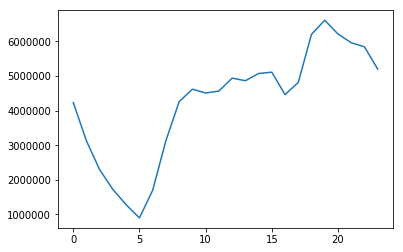

In [126]:
linea.compute()

Día de la semana

In [0]:
linea = graficas9(aaa)

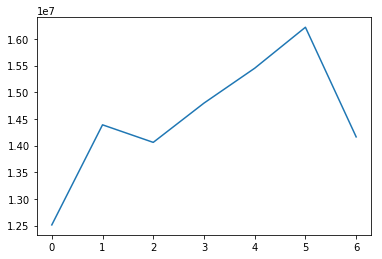

In [128]:
linea.compute()

## 10. Elegir el vehiculo con mas viajes en cada mes y graficar en un mapa los sitios donde se suben pasajeros agrupados por
   * dia de la semana (un color distinto para cada dia)
   * hora del dia (un color distinto para cada intervalo de cuatro horas,00:00 - 03:59, 04:00--07:59, 08:00-11:59, etc.)

In [0]:
vehiculos = aaa.groupby('medallion')

In [0]:
mp = vehiculos['passenger_count'] == vehiculos['passenger_count'].max()

In [0]:
mp = mp.to_frame()

In [100]:
mp

,passenger_count
npartitions=1,
,bool
,...


In [101]:
mp.head()

,passenger_count
medallion,
000318C2E3E6381580E5C99910A60668,False
002B4CFC5B8920A87065FC131F9732D1,False
002E3B405B6ABEA23B6305D3766140F1,False
0030AD2648D81EE87796445DB61FCF20,False
0035520A854E4F2769B37DAF5357426F,False


In [114]:
localizado = aaa.loc[mp, 'True']

KeyError: ignored

In [113]:
localizado.columns

Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_time_in_secs', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'archivo',
       'duracion', 'hora', 'dia_semana'],
      dtype='object')

In [104]:
localizado.head()

TypeError: ignored

In [86]:
aaa['medallion']

Dask Series Structure:
npartitions=157
    object
       ...
     ...  
       ...
       ...
Name: medallion, dtype: object
Dask Name: getitem, 6908 tasks

In [87]:
mp['medallion']

Dask Series Structure:
npartitions=1
    object
       ...
Name: medallion, dtype: object
Dask Name: getitem, 6936 tasks

In [89]:
mas_pasajeros = aaa.loc[mp['medallion']]

ValueError: ignored

In [84]:
type(mas_pasajeros)

dask.dataframe.core.DataFrame

In [85]:
mas_pasajeros.head()

TypeError: ignored

# Previo
Instrucciones contruidas sobre el archivo previo a edición propia.

In [0]:
cuantosTaxis=viajes_largos['medallion'].value_counts()
cuantosTaxis[0]

2137

In [0]:
# selecciona
este="7E1346F23960CC18D7D129FA28B63A75"
# taxi

In [0]:
estos=df[df.medallion==este]

In [0]:
estos.columns

Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_time_in_secs', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'hour', 'weekday'],
      dtype='object')

In [0]:
# convert dropoff times to datetimes
# estos['dropoff_datetime'] = pd.to_datetime(estos['dropoff_datetime'])
estos['hour'] = estos['dropoff_datetime'].dt.hour
estos['weekday'] = estos['dropoff_datetime'].dt.weekday

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
estePorHora = estos.groupby('hour')

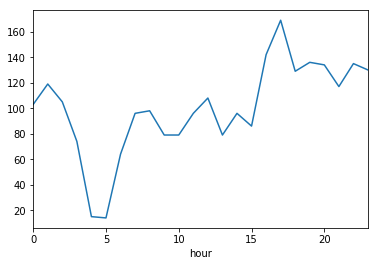

In [0]:

estePorHora['passenger_count'].sum().plot.line()

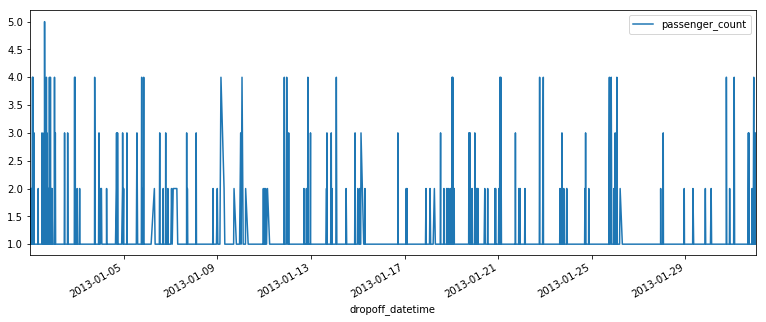

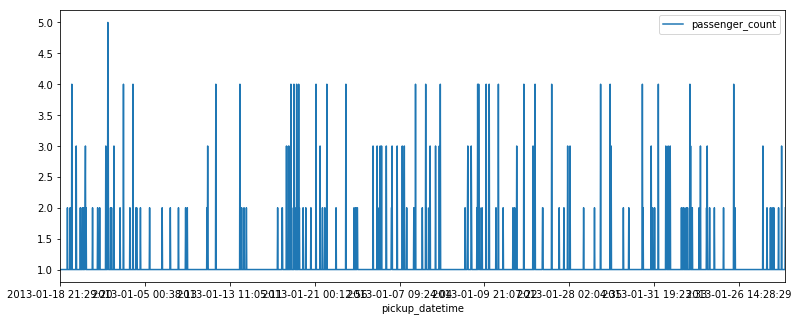

In [0]:
estos.plot.line(x='dropoff_datetime', y='passenger_count', figsize=(13,5))
estos.plot.line(x='pickup_datetime', y='passenger_count', figsize=(13,5))